#  Intro

The aim of the notebook is to evaluate the proposed  discretisation method for $R^2$.

# TODO

Posprawdzaj wymiary w samplach, gdzieś się po drodze zamieniają ze sobą osie.

Pomyśl jak to wizualizować (może kostka do obracania  z kolorowymi punktami zamiast kostek?  Albo animacja z każdego pola gdzie w 2d można trafić. Może prościej będzie rysować więcej stanów naraz?


In [35]:
import itertools

import numpy as np
import itertools
from utils import dtv, permute_embeddings, compute_stationary,  empirical_coocs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from eval_utils import visualize_matrix
import scipy.linalg as sla
from scipy.stats import multivariate_normal as mvn

In [36]:
np.random.seed(2022)

In [37]:
def prepare_params2d(n, simple_model=True):
    A = np.exp(np.random.uniform(0, 5, size=(n, n)))
    A /= A.sum(axis=1)[:, np.newaxis]
    pi = compute_stationary(A)

    # TODO:  mu, sigma

    return pi, A  #, mu, sigma

In [38]:
def my_hmm_sampler2d(pi, A, mu, sigma, T):
    n = pi.shape[0]
    X = [np.random.choice(n, 1, replace=True, p=pi)]
    for t in range(T - 1):
        X.append(np.random.choice(n, 1, replace=True, p=A[X[t][0], :]))
    Y = np.concatenate([np.random.multivariate_normal(mu[s[0]], sigma[s[0]], 1) for s in X])#.reshape(-1, 1)
    return X, Y

In [39]:
mean1 = np.array([2, 3])
mean2 = np.array([-1, -1])
mean3 = np.array([-2, 2])
mu =  np.concatenate([mean1.reshape(1, -1), mean2.reshape(1, -1), mean3.reshape(1, -1)])

covar1 = np.array([[1,  0.5],  [0.5,  1.2]])
covar2 = np.array([[1,  -0.7],  [-0.7,  0.9]])
covar3 = np.array([[0.8,  0.5],  [0.5,  0.8]])
sigma = np.concatenate([covar1[np.newaxis,  :, :], covar2[np.newaxis,  :, :], covar3[np.newaxis,  :, :]])

pi,  A = prepare_params2d(n=3)

sample = my_hmm_sampler2d(pi, A, mu, sigma, T=500000)

In [40]:
Y = sample[1]
X = np.concatenate(sample[0])

In [41]:
sample1 = Y[X == 0, :]
sample2 = Y[X == 1, :]
sample3 = Y[X == 2, :]

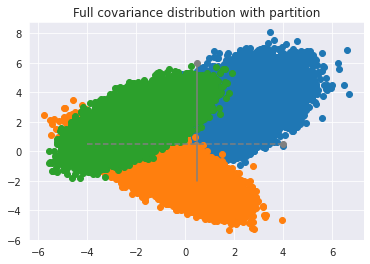

In [42]:
samples = [sample1, sample2, sample3]

for i in range(3):
    s = samples[i]
    plt.scatter(s[:, 0], s[:, 1])

lin1 = np.array([[(i*8) / 1000 - 4,  0.5] for i in range(1000)])
lin2 = np.array([[0.5, (i*8) / 1000 - 2] for i in range(1000)])

plt.plot(lin1[:, 0], lin1[:, 1], color="grey", linestyle="--")
plt.scatter(lin1[-1, 0], lin1[-1, 1], color="grey")
plt.plot(lin2[:, 0], lin2[:, 1], color="grey")
plt.scatter(lin2[-1, 0], lin2[-1, 1], color="grey")
plt.title("Full covariance distribution with partition")
plt.show()

In [43]:
# sample = np.concatenate(samples)

In [44]:
n=3
dtree = DecisionTreeClassifier(max_depth=np.ceil(np.log2(n)).astype(int)).fit(Y, X)

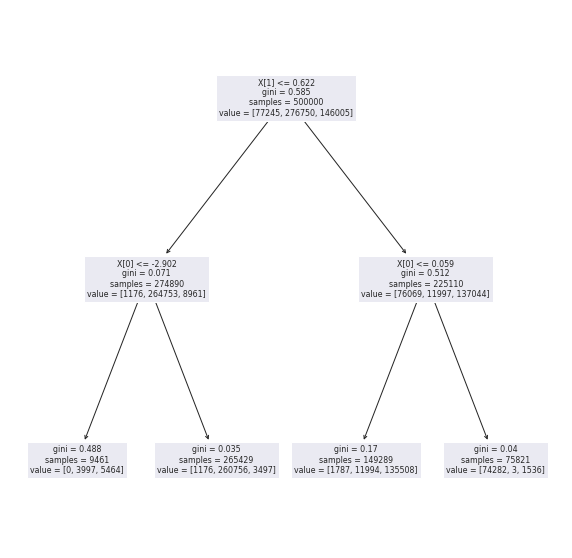

In [45]:
plt.figure(figsize=(10, 10))
plot_tree(dtree)
plt.show()

In [46]:
splits = np.concatenate([dtree.tree_.feature.reshape(-1, 1), dtree.tree_.threshold.reshape(-1, 1)], axis=1)
splits = np.concatenate([splits,  np.array([[0, Y[:, 0].min() - 1e-3],
                                            [0, Y[:, 0].max() + 1e-3],
                                            [1, Y[:, 1].min() - 1e-3],
                                            [1, Y[:, 1].max() + 1e-3]
                                            ])])
splits = splits[splits[:, 0] >= 0]
splits

array([[ 1.        ,  0.62217915],
       [ 0.        , -2.90240383],
       [ 0.        ,  0.05929768],
       [ 0.        , -5.76110248],
       [ 0.        ,  6.67440408],
       [ 1.        , -5.33329088],
       [ 1.        ,  8.07424293]])

In [47]:
nodes_x = splits[splits[:, 0] == 0.0,  1]
nodes_y = splits[splits[:, 0] == 1.0,  1]

nodes_x = np.sort(nodes_x)
display(nodes_x)
nodes_y = np.sort(nodes_y)
display(nodes_y)


nodes = []
for y,  x in itertools.product(nodes_y, nodes_x):
    nodes.append((x, y))
nodes = np.array(nodes)
nodes

array([-5.76110248, -2.90240383,  0.05929768,  6.67440408])

array([-5.33329088,  0.62217915,  8.07424293])

array([[-5.76110248, -5.33329088],
       [-2.90240383, -5.33329088],
       [ 0.05929768, -5.33329088],
       [ 6.67440408, -5.33329088],
       [-5.76110248,  0.62217915],
       [-2.90240383,  0.62217915],
       [ 0.05929768,  0.62217915],
       [ 6.67440408,  0.62217915],
       [-5.76110248,  8.07424293],
       [-2.90240383,  8.07424293],
       [ 0.05929768,  8.07424293],
       [ 6.67440408,  8.07424293]])

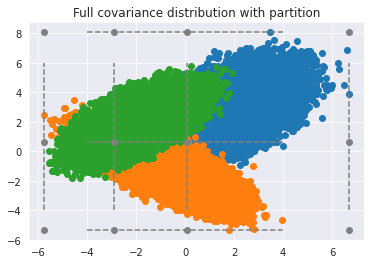

In [48]:
for i in range(3):
    s = samples[i]
    plt.scatter(s[:, 0], s[:, 1])

for i in range(len(splits)):
    if splits[i,  0] == 0.0:   #  vertical
        lin = np.array([[splits[i,  1], (j*10) / 1000 - 4] for j in range(1000)])
    else:   #  horizontal
        lin = np.array([[(j*8) / 1000 - 4, splits[i,  1]] for j in range(1000)])
    plt.plot(lin[:, 0], lin[:, 1], color="grey", linestyle="--")

for node in nodes:
    plt.scatter(node[0], node[1], color="grey")

plt.title("Full covariance distribution with partition")
plt.show()

In [49]:
indexes = np.arange((nodes_x.shape[0]+1) * (nodes_y.shape[0]+1)).reshape((nodes_y.shape[0]+1), (nodes_x.shape[0]+1))
indexes = indexes[-np.arange(1, 5), :]
indexes

array([[15, 16, 17, 18, 19],
       [10, 11, 12, 13, 14],
       [ 5,  6,  7,  8,  9],
       [ 0,  1,  2,  3,  4]])

In [70]:
ind =  indexes[np.cumsum(Y[:, 1].reshape(-1, 1) > nodes_y.reshape(1, -1), axis=1).max(axis=1),
               np.cumsum(Y[:, 0].reshape(-1, 1) > nodes_x.reshape(1,  -1), axis=1).max(axis=1),]

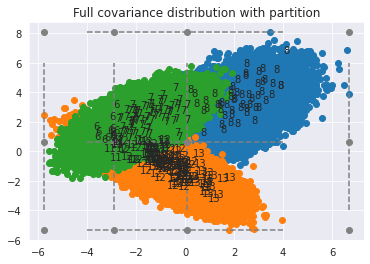

In [71]:
for i in range(3):
    s = samples[i]
    plt.scatter(s[:, 0], s[:, 1])

for i in range(len(splits)):
    if splits[i,  0] == 0.0:   #  vertical
        lin = np.array([[splits[i,  1], (j*10) / 1000 - 4] for j in range(1000)])
    else:   #  horizontal
        lin = np.array([[(j*8) / 1000 - 4, splits[i,  1]] for j in range(1000)])
    plt.plot(lin[:, 0], lin[:, 1], color="grey", linestyle="--")

for node in nodes:
    plt.scatter(node[0], node[1], color="grey")

plt.title("Full covariance distribution with partition")

for i in range(300):
    plt.text(Y[i, 0], Y[i, 1],  ind[i])
plt.show()

In [72]:
# ind --> Y_disc (append zero margin)
# for  unknown hidden states we could use GMM / zero places of the derivative zeros to provide class for the tree division

In [73]:
_, cooc_freq = empirical_coocs(ind.reshape(1, -1), indexes.max() + 1)

In [74]:
cooc_freq

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

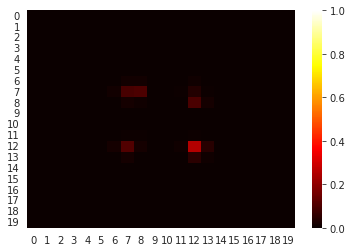

In [75]:
visualize_matrix(cooc_freq)

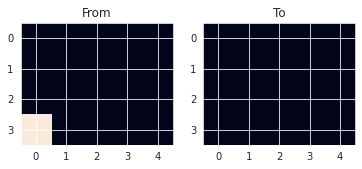

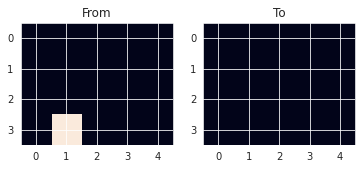

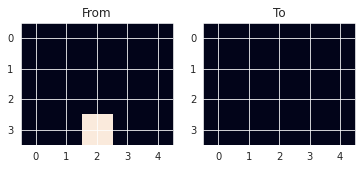

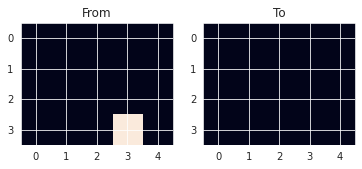

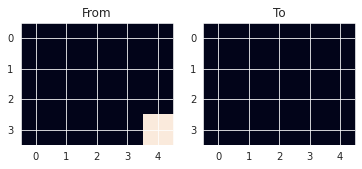

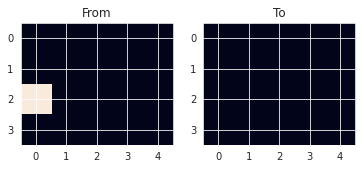

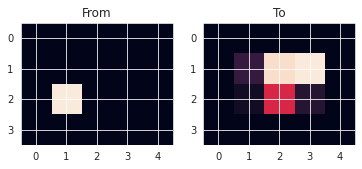

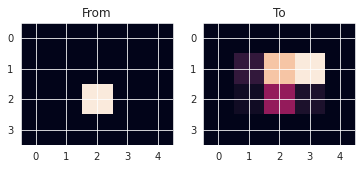

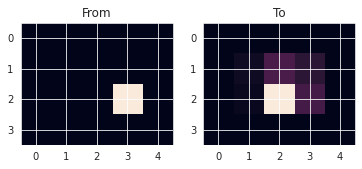

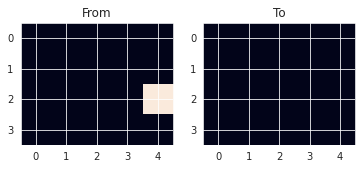

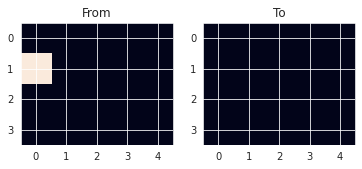

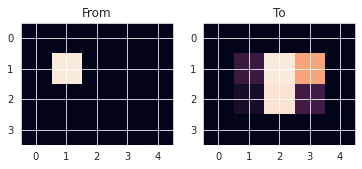

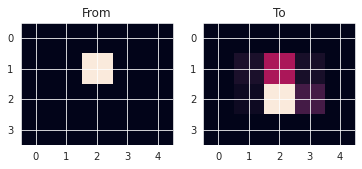

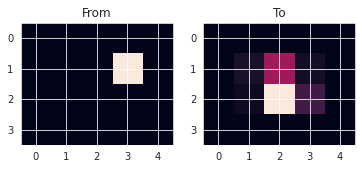

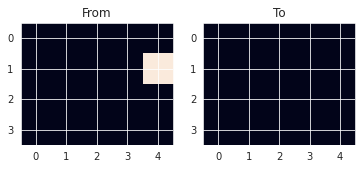

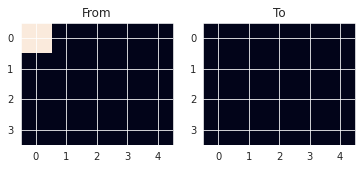

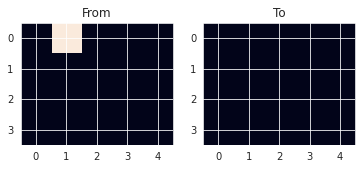

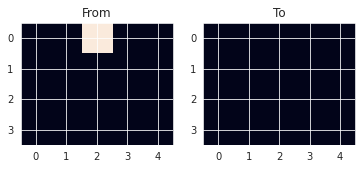

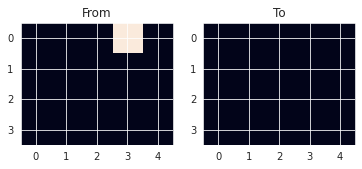

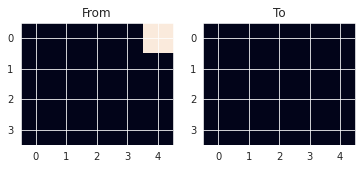

In [76]:
for i  in range(indexes.max() + 1):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(indexes == i)
    axs[0].set_title("From")
    axs[1].imshow(cooc_freq[i].reshape(indexes.shape))
    axs[1].set_title("To")
    plt.show()

In [77]:
dist = mvn(mean=mean1, cov=covar1)
print("CDF:", dist.cdf(np.array([2, 4])))

CDF: 0.4577516136702326


In [78]:
dists = [mvn(mean=m, cov=c) for  m,  c  in zip(mu, sigma)]

In [79]:
nodes.argsort(axis=0)

array([[ 0,  0],
       [ 4,  1],
       [ 8,  2],
       [ 1,  3],
       [ 5,  4],
       [ 9,  5],
       [ 2,  6],
       [ 6,  7],
       [10,  8],
       [ 3,  9],
       [ 7, 10],
       [11, 11]])

In [80]:
n_x = np.concatenate([splits[splits[:, 0] == 0.0,  1], np.array([np.infty])])
n_y = np.concatenate([splits[splits[:, 0] == 1.0,  1], np.array([np.infty])])

n_x = np.sort(n_x)
display(n_x)
n_y = np.sort(n_y)
display(n_y)


nodes2 = []
for y,  x in itertools.product(n_y, n_x):
    nodes2.append((x, y))
nodes2 = np.array(nodes2)
nodes2

array([-5.76110248, -2.90240383,  0.05929768,  6.67440408,         inf])

array([-5.33329088,  0.62217915,  8.07424293,         inf])

array([[-5.76110248, -5.33329088],
       [-2.90240383, -5.33329088],
       [ 0.05929768, -5.33329088],
       [ 6.67440408, -5.33329088],
       [        inf, -5.33329088],
       [-5.76110248,  0.62217915],
       [-2.90240383,  0.62217915],
       [ 0.05929768,  0.62217915],
       [ 6.67440408,  0.62217915],
       [        inf,  0.62217915],
       [-5.76110248,  8.07424293],
       [-2.90240383,  8.07424293],
       [ 0.05929768,  8.07424293],
       [ 6.67440408,  8.07424293],
       [        inf,  8.07424293],
       [-5.76110248,         inf],
       [-2.90240383,         inf],
       [ 0.05929768,         inf],
       [ 6.67440408,         inf],
       [        inf,         inf]])

In [82]:
cdfs = [np.nan_to_num(d.cdf(nodes2).reshape((n_y.shape[0]), (n_x.shape[0]))[-np.arange(1, n_y.shape[0]+1), :]) for d in dists]
cdfs  # , np.newaxis

probs  = [c -
          np.concatenate([np.zeros(c.shape[0]).reshape(c.shape[0], 1), c[:, :-1]],  axis=1) -
          np.concatenate([c[1:, :],  np.zeros(c.shape[1]).reshape(1, c.shape[1])]) +
          np.concatenate([np.zeros(c.shape[0]).reshape(c.shape[0], 1),  np.concatenate([c[1:,  :-1],  np.zeros(c.shape[1] -  1).reshape(1, c.shape[1] - 1)],  axis=0)], axis=1) for c in cdfs]
probs

probs_flat = np.concatenate([p.reshape(-1, 1) for p  in probs],  axis=1)
probs_flat
# indexes = np.arange((nodes_x.shape[0]+1) * (nodes_y.shape[0]+1)).reshape((nodes_y.shape[0]+1), (nodes_x.shape[0]+1))
# indexes = indexes[-np.arange(1, 5), :]
# indexes

array([[-6.78420378e-29,  6.35274710e-22,  1.69406589e-21],
       [ 1.57605930e-21, -1.58818678e-18,  3.48469355e-18],
       [ 3.12597028e-12, -4.51028104e-17,  2.68673972e-14],
       [ 1.80438330e-06,  0.00000000e+00,  5.53301849e-12],
       [ 5.23741306e-09,  0.00000000e+00,  0.00000000e+00],
       [ 2.29398203e-16,  9.60511960e-07,  7.94838868e-07],
       [ 2.04425110e-07,  1.38021455e-02,  1.19077613e-01],
       [ 2.32861848e-02,  2.98321410e-02,  8.08539330e-01],
       [ 9.61731268e-01,  4.44279272e-06,  1.06569765e-02],
       [ 1.46880384e-06,  0.00000000e+00,  0.00000000e+00],
       [ 3.98029950e-15,  2.17925812e-09,  1.22569371e-05],
       [ 2.68929710e-07,  1.47560820e-02,  3.74162788e-02],
       [ 2.86053901e-03,  7.96876552e-01,  2.42964215e-02],
       [ 1.21182566e-02,  1.44725209e-01,  3.27788312e-07],
       [ 6.36272285e-13,  3.53081449e-16,  0.00000000e+00],
       [ 1.47440871e-20, -1.62440420e-22,  1.08887923e-16],
       [ 8.67074122e-16,  3.30717048e-19

In [83]:
probs_flat

array([[-6.78420378e-29,  6.35274710e-22,  1.69406589e-21],
       [ 1.57605930e-21, -1.58818678e-18,  3.48469355e-18],
       [ 3.12597028e-12, -4.51028104e-17,  2.68673972e-14],
       [ 1.80438330e-06,  0.00000000e+00,  5.53301849e-12],
       [ 5.23741306e-09,  0.00000000e+00,  0.00000000e+00],
       [ 2.29398203e-16,  9.60511960e-07,  7.94838868e-07],
       [ 2.04425110e-07,  1.38021455e-02,  1.19077613e-01],
       [ 2.32861848e-02,  2.98321410e-02,  8.08539330e-01],
       [ 9.61731268e-01,  4.44279272e-06,  1.06569765e-02],
       [ 1.46880384e-06,  0.00000000e+00,  0.00000000e+00],
       [ 3.98029950e-15,  2.17925812e-09,  1.22569371e-05],
       [ 2.68929710e-07,  1.47560820e-02,  3.74162788e-02],
       [ 2.86053901e-03,  7.96876552e-01,  2.42964215e-02],
       [ 1.21182566e-02,  1.44725209e-01,  3.27788312e-07],
       [ 6.36272285e-13,  3.53081449e-16,  0.00000000e+00],
       [ 1.47440871e-20, -1.62440420e-22,  1.08887923e-16],
       [ 8.67074122e-16,  3.30717048e-19

In [84]:
indexes

array([[15, 16, 17, 18, 19],
       [10, 11, 12, 13, 14],
       [ 5,  6,  7,  8,  9],
       [ 0,  1,  2,  3,  4]])

In [85]:
cdfs[0]

array([[4.20971244e-15, 4.73354825e-07, 2.61471971e-02, 9.99998526e-01,
        1.00000000e+00],
       [4.20971244e-15, 4.73354825e-07, 2.61471971e-02, 9.99996722e-01,
        9.99998190e-01],
       [3.98031424e-15, 2.68929715e-07, 2.86080794e-03, 1.49790645e-02,
        1.49790645e-02],
       [1.47440871e-20, 8.67088866e-16, 1.34806683e-14, 1.40028285e-14,
        1.40028285e-14]])

In [86]:
probs_flat.shape

(20, 3)

In [87]:
cooc_dist = np.matmul(probs_flat,  np.matmul(A* pi[:, None], np.transpose(probs_flat)))
cooc_dist

array([[ 7.18687143e-43,  5.77784046e-40,  7.15330790e-34,
         4.08146058e-28,  1.18468209e-30,  5.43355517e-28,
         4.09161194e-23,  2.63207166e-22,  2.20818606e-22,
         3.32237612e-28,  3.77014523e-27,  1.60990829e-23,
         2.56108317e-22,  4.77799111e-23,  1.44032150e-34,
         3.34903973e-38,  2.00058100e-37,  1.27927583e-31,
         7.67185311e-28,  2.48139392e-36],
       [ 4.23795818e-41,  1.52475305e-36,  1.31203255e-30,
         7.54049575e-25,  2.18870512e-27, -3.08924571e-25,
         1.82924966e-20,  1.65646534e-19,  4.04153707e-19,
         6.13810379e-25,  2.58696323e-24,  5.76291209e-22,
        -3.89207581e-19, -6.67707258e-20,  2.65721744e-31,
         2.29978617e-35,  3.64811668e-34, -2.04029706e-28,
        -1.22363079e-24, -3.95772696e-33],
       [ 3.52250791e-34, -4.13947353e-31,  1.18295632e-25,
         6.73561861e-20,  1.95507471e-22,  4.25813919e-19,
         1.26259612e-14,  6.14737949e-14,  3.65463810e-14,
         5.48290010e-20,  7.4

In [88]:
cooc_dist.sum()


1.0

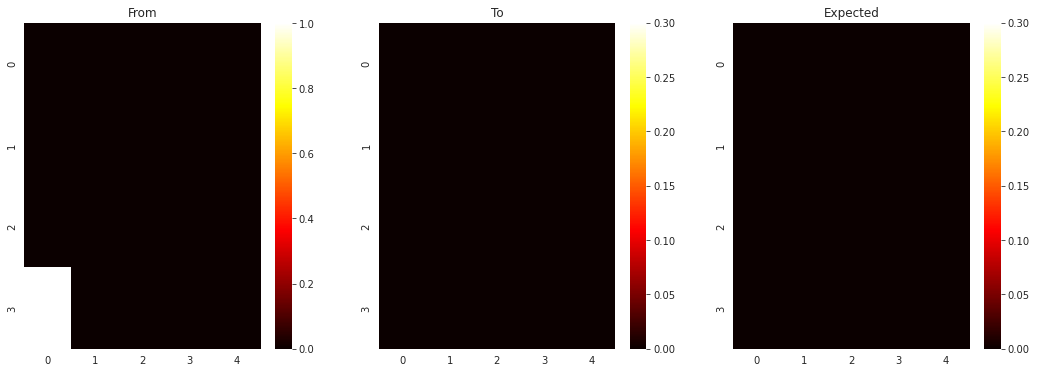

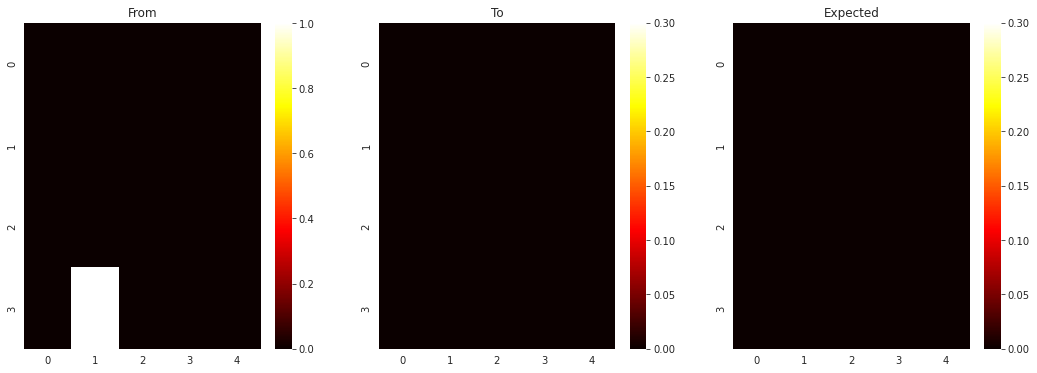

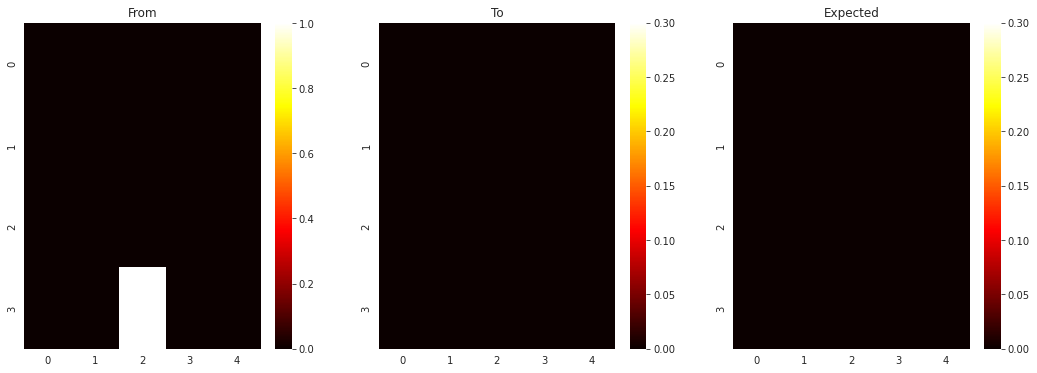

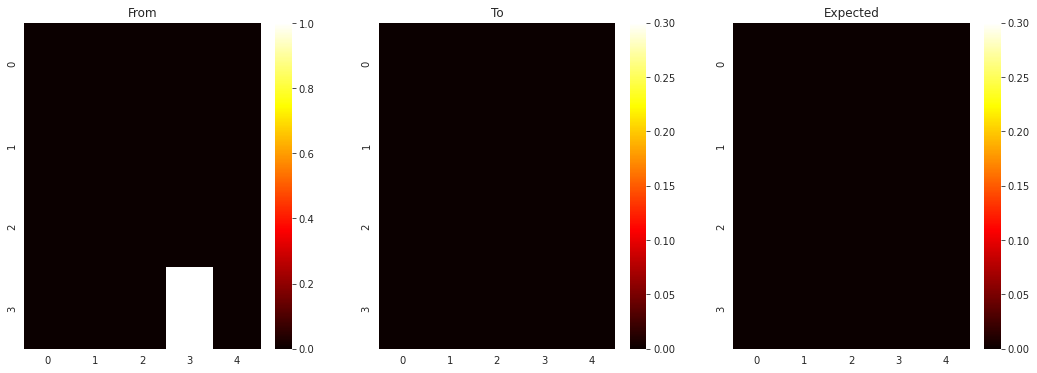

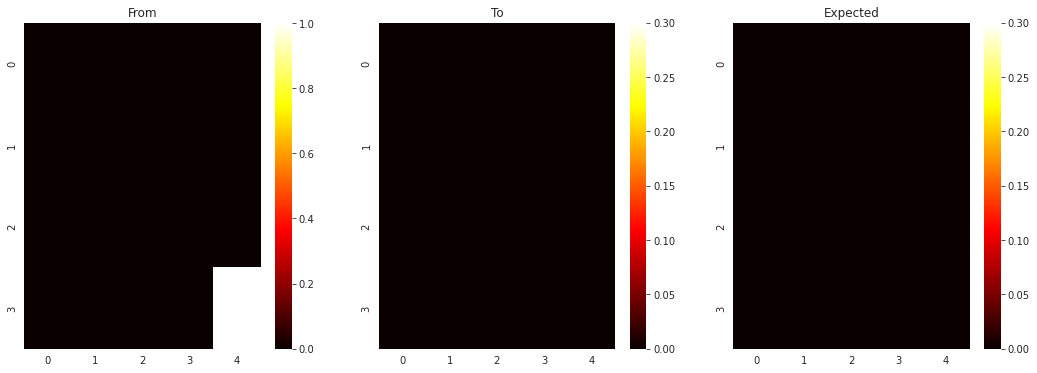

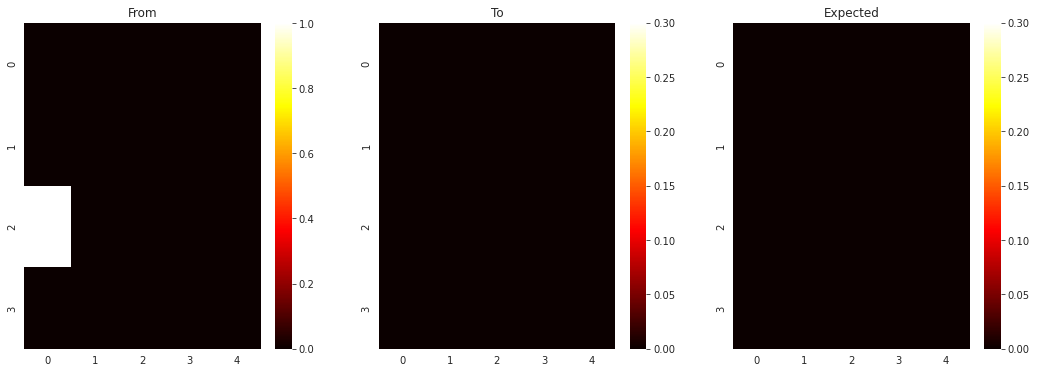

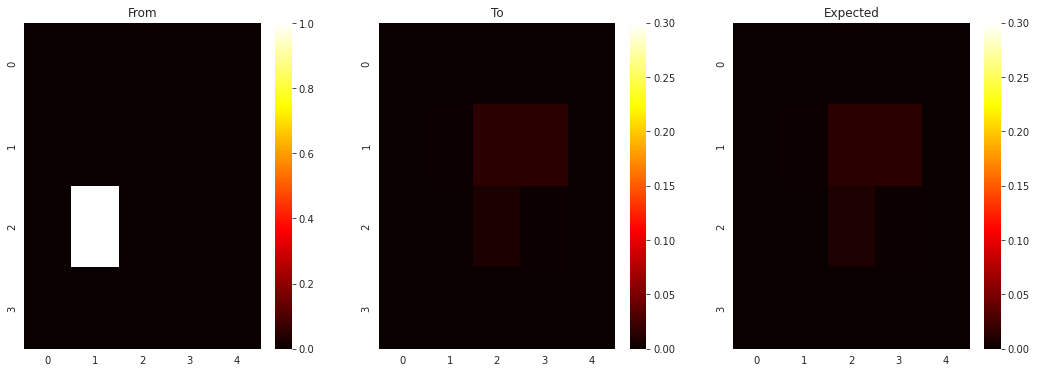

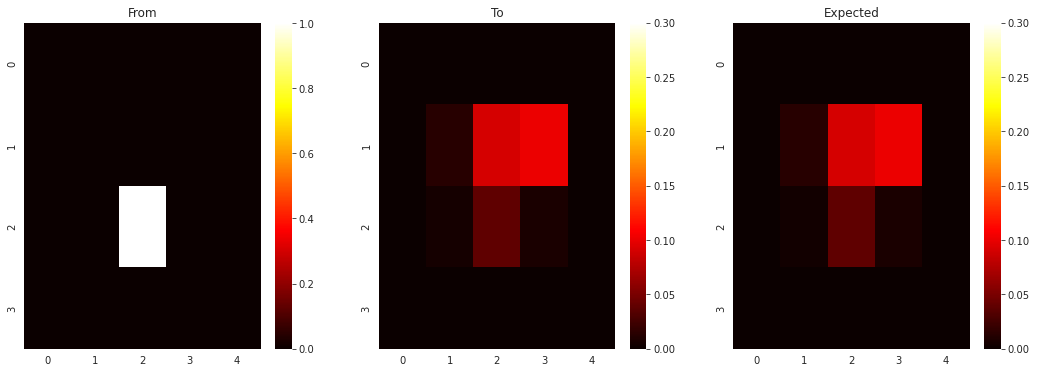

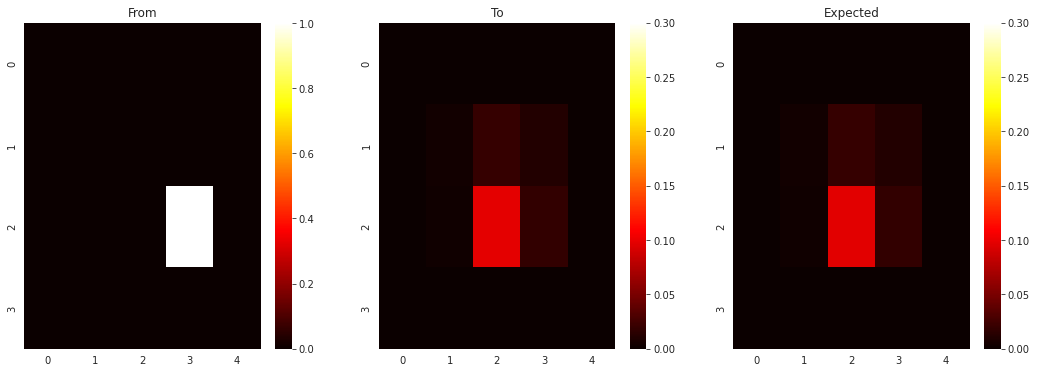

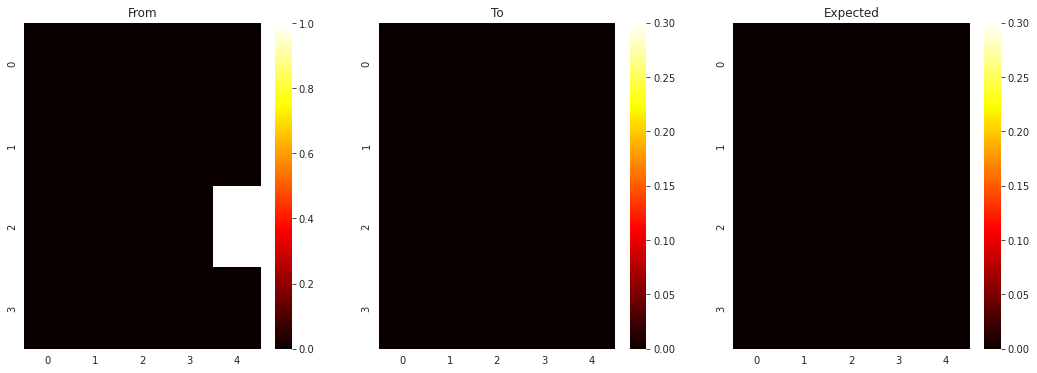

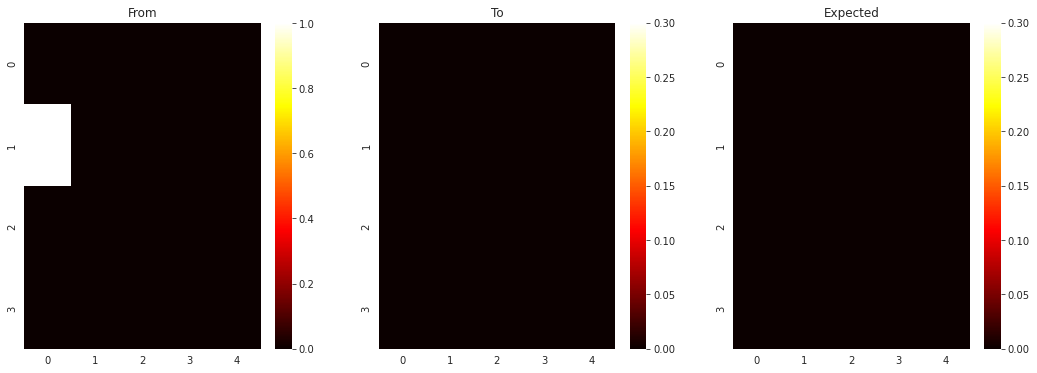

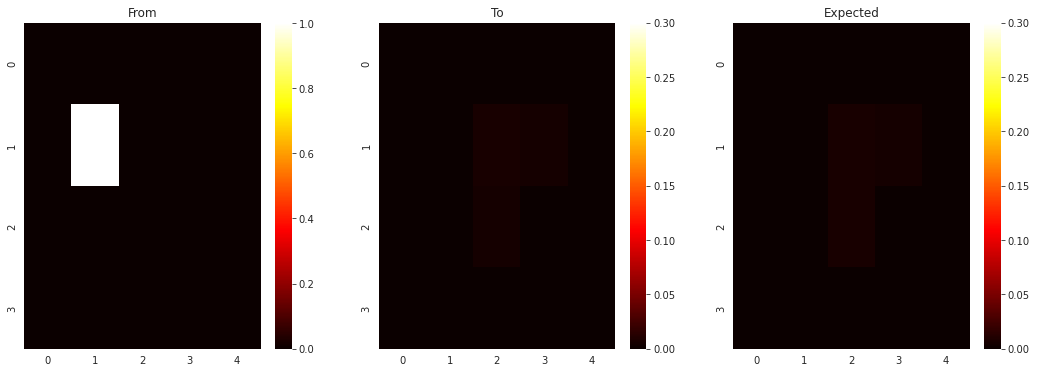

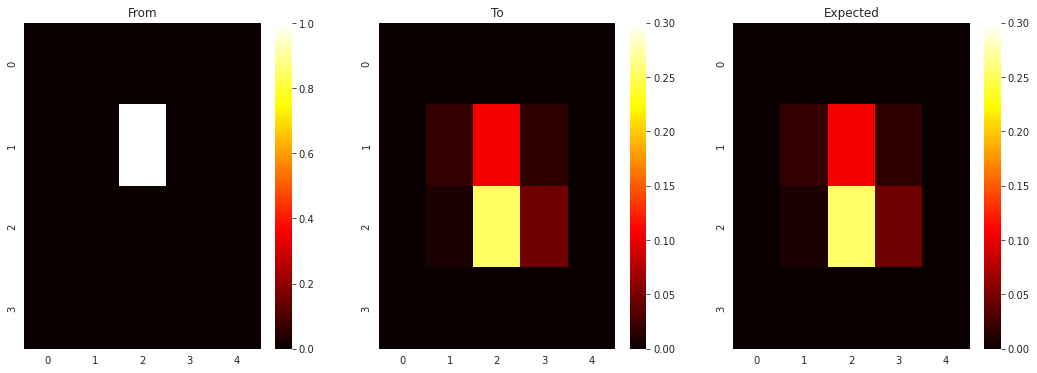

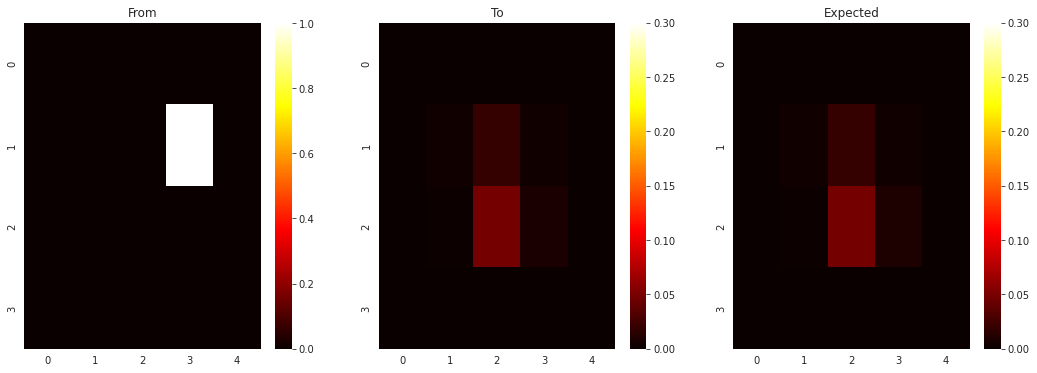

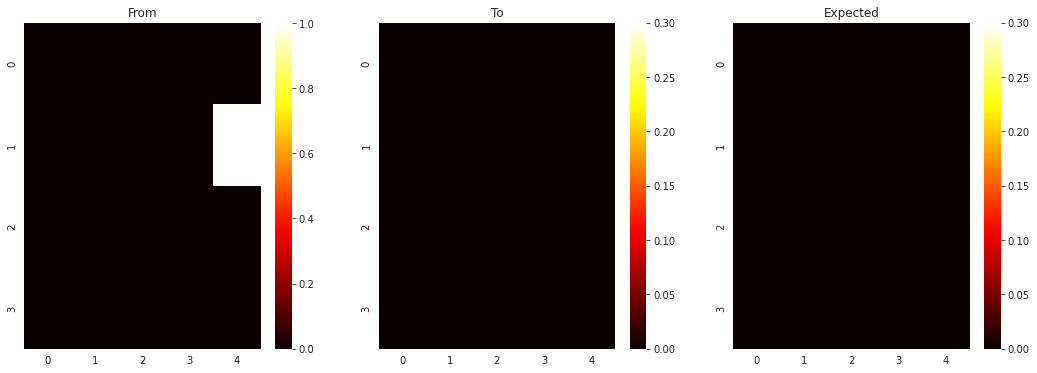

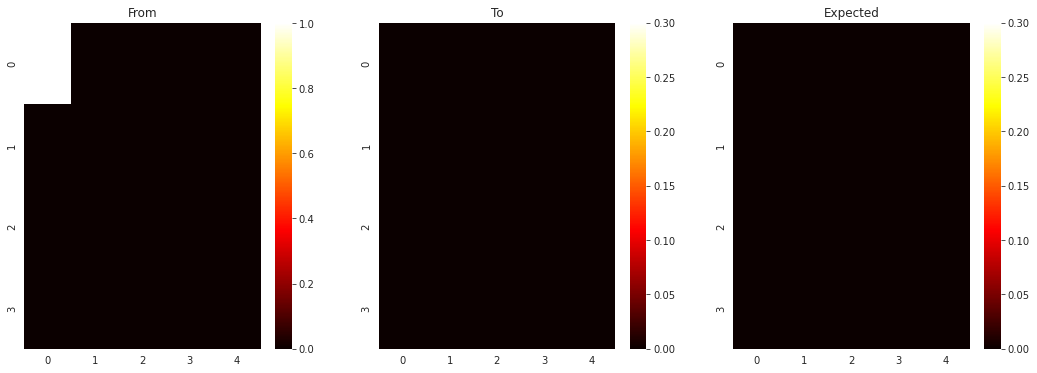

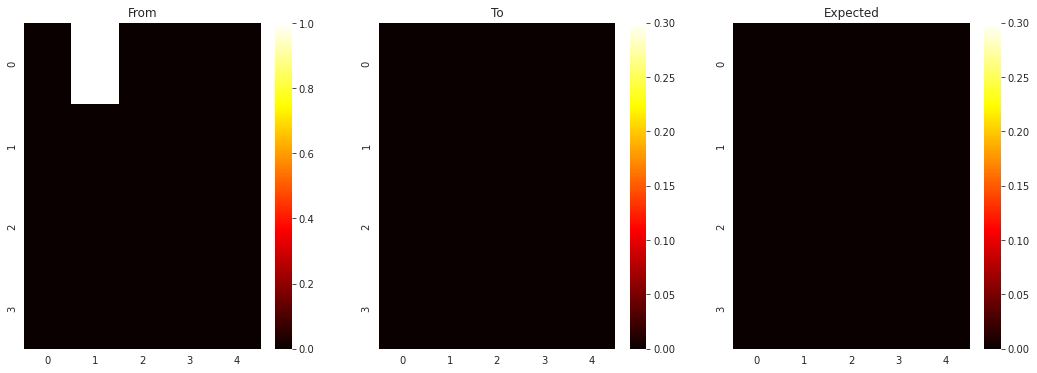

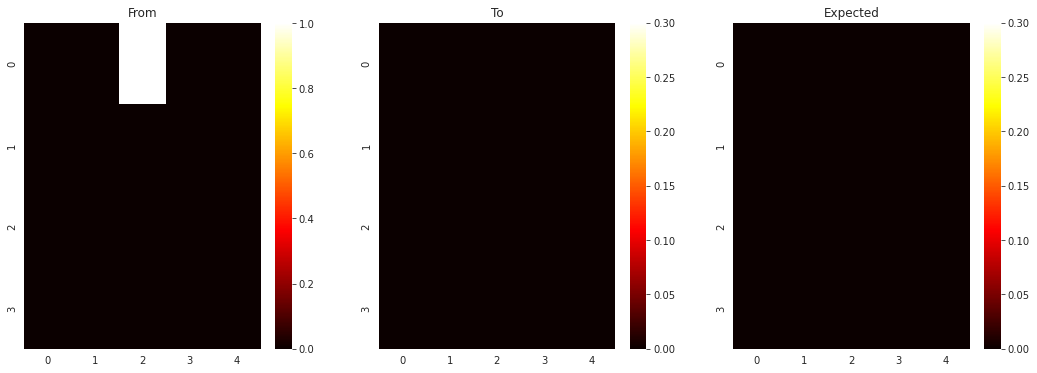

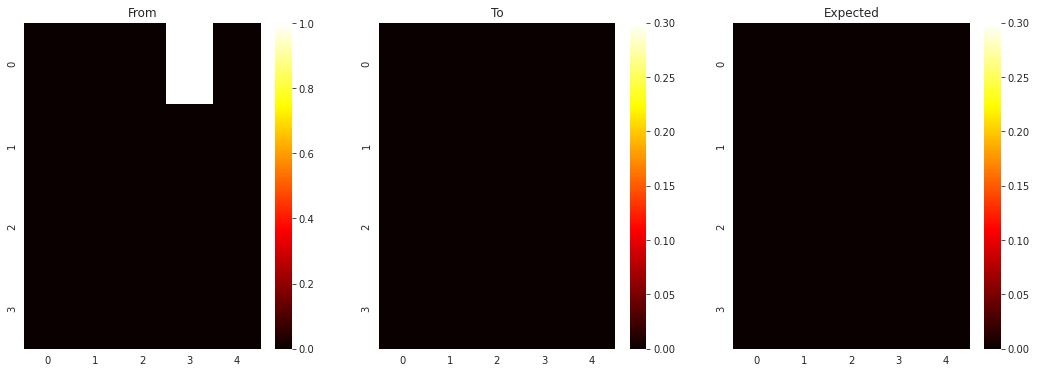

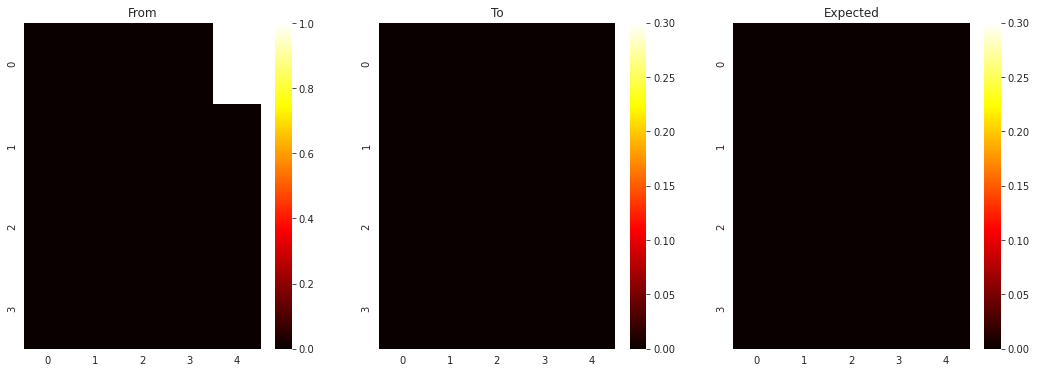

In [93]:
vmax = .3
for i  in range(indexes.max() + 1):
    fig, axs = plt.subplots(1, 3,  figsize=(18, 6))
    # axs[0].imshow(indexes == i)
    sns.heatmap((indexes == i).astype(float), cmap="hot", vmax=1.001, ax=axs[0])
    axs[0].set_title("From")
    # axs[1].imshow(cooc_freq[i].reshape(indexes.shape))
    sns.heatmap(cooc_freq[i].reshape(indexes.shape), cmap="hot", vmax=vmax, ax=axs[1])
    axs[1].set_title("To")
    # axs[2].imshow(cooc_dist[i].reshape(indexes.shape))
    sns.heatmap(cooc_dist[i].reshape(indexes.shape), cmap="hot", vmax=vmax, ax=axs[2])
    axs[2].set_title("Expected")
    plt.show()